In [53]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from geopy.distance import distance
import xgboost 

In [2]:
class ProjectKNN:
    data = None
    data_train = None
    data_test = None
    model = None
    optimizer = None
    loss_function = None
    model_loss = 10000
    early_stop = 0

    def __init__(self, data_path='LocTreino_Equipe_3.csv', log_dir='log_mlp/'):
        self.data = pd.read_csv(data_path)
        self.preproccess_data()
        self.split_data()
        self.declare_model()

    def preproccess_data(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna()

    def split_data(self):
        self.X = self.data[[
            x for x in self.data.columns if x not in ('lat', 'lon')]].values
        self.y = self.data[[
            x for x in self.data.columns if x in ('lat', 'lon')]].values

        self.data_train = self.data_test = self.data
        self.data_train = self.data_train[:int(0.9 * len(self.data_train))]
        self.data_test = self.data_test[int(0.9 * len(self.data_test)):]

    def declare_model(self):
        params = {'n_neighbors': [1, 3, 5, 8, 13],
                  'metric': ['euclidian', 'manhattan'],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [30, 33, 55, 88]
                  }
        knn = KNeighborsRegressor()
        self.model = GridSearchCV(knn, params,
                                  verbose=1, cv=3, n_jobs=-1)

    def train(self):
        batch = self.data_train
        x_batch = batch[[
            x for x in batch.columns if x not in ('lat', 'lon')]].values
        y_batch = batch[[
            x for x in batch.columns if x in ('lat', 'lon')]].values

        self.model.fit(x_batch, y_batch)
        self.model = knn.model.best_estimator_
        print(self.model)

    def test(self):
        x_batch = self.data_test[[
            x for x in self.data_test.columns if x not in ('lat', 'lon')]].values
        y_batch = self.data_test[[
            x for x in self.data_test.columns if x in ('lat', 'lon')]].values

        out = self.model.predict(x_batch)
        return out, y_batch

In [3]:
knn = ProjectKNN()
knn.train()
out, y_batch = knn.test()

Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.1s


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                    weights='distance')


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.4s finished


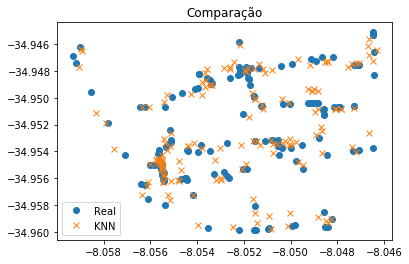

Erro Médio: 49.07206910236095
Erro Mínimo: 3.1391564778270498
Erro Máximo: 177.53606700090577
Desvio Padrão: 35.39081151945304


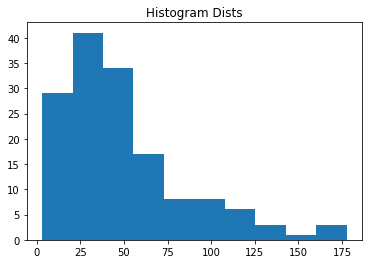

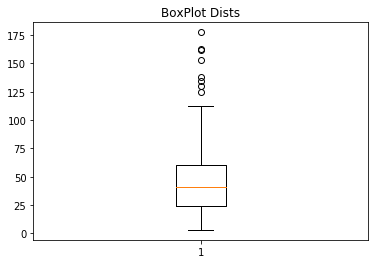

In [92]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in y_batch], [x[1] for x in y_batch], 'o', label='Real')
ax.plot([x[0] for x in out], [x[1] for x in out], 'x', label='KNN')
ax.legend()
ax.set_title('Comparação')
plt.show()
error = y_batch - out
errors_x = error[:, 0]
errors_y = error[:, 1]


dists = []
for i in range(len(out)):
    dist = distance(y_batch[i], out[i]).km*1000
    dists.append(dist)

print(f'Erro Médio: {np.mean(dists)}\nErro Mínimo: {min(dists)}\nErro Máximo: {max(dists)}\nDesvio Padrão: {np.std(dists)}')

fig, ax = plt.subplots()
ax.hist(dists, 10)
ax.set_title('Histogram Dists')
plt.show()

fig, ax = plt.subplots()
ax.boxplot(dists)
ax.set_title('BoxPlot Dists')
plt.show()

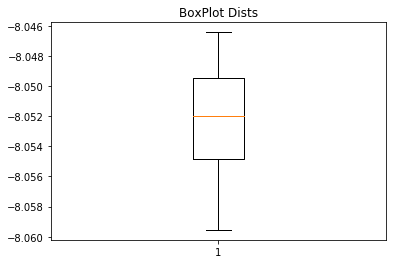

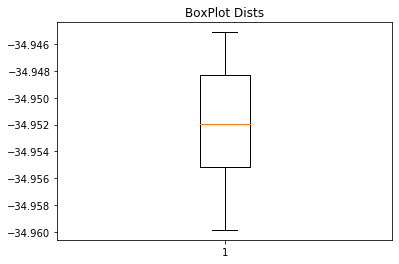

In [33]:
lat = knn.data.lat
lon = knn.data.lon

lat = lat.values
lon = lon.values

fig, ax = plt.subplots()
ax.boxplot(lat)
ax.set_title('BoxPlot Dists')
plt.show()
fig, ax = plt.subplots()
ax.boxplot(lon)
ax.set_title('BoxPlot Dists')
plt.show()

In [ ]:
parameters_for_testing = {
   'colsample_bytree':[0.4,0.6,0.8],
   'gamma':[0,0.03,0.1,0.3],
   'min_child_weight':[1.5,6,10],
   'learning_rate':[0.1,0.07],
   'max_depth':[3,5],
   'n_estimators':[10000],
   'reg_alpha':[1e-5, 1e-2,  0.75],
   'reg_lambda':[1e-5, 1e-2, 0.45],
   'subsample':[0.6,0.95]  
}

xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=1000, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)

In [89]:
class ProjectXGBOOST:
    data = None
    data_train = None
    data_test = None
    model = None
    optimizer = None
    loss_function = None
    model_loss = 10000
    early_stop = 0

    def __init__(self, data_path='LocTreino_Equipe_3.csv', log_dir='log_mlp/'):
        self.data = pd.read_csv(data_path)
        self.preproccess_data()
        self.split_data()
        self.declare_model()

    def preproccess_data(self):
        self.data = self.data.drop_duplicates()
        self.data = self.data.dropna()

    def split_data(self):
        self.X = self.data[[
            x for x in self.data.columns if x not in ('lat', 'lon')]].values
        self.y = self.data[[
            x for x in self.data.columns if x in ('lat', 'lon')]].values

        self.data_train = self.data_test = self.data
        self.data_train = self.data_train[:int(0.9 * len(self.data_train))]
        self.data_test = self.data_test[int(0.9 * len(self.data_test)):]

    def declare_model(self):
        self.model_lat = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 n_estimators=10000,                                                      
                 objective='reg:squarederror')
        self.model_lon = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 n_estimators=10000,                                                      
                 objective='reg:squarederror')

    def train(self):
        batch = self.data_train
        x_batch = batch[[
            x for x in batch.columns if x not in ('lat', 'lon')]].values
        y_batch = batch[[
            x for x in batch.columns if x in ('lat', 'lon')]].values

        self.model_lat.fit(x_batch, batch.lat)
        self.model_lon.fit(x_batch, batch.lon)
        

    def test(self):
        x_batch = self.data_test[[
            x for x in self.data_test.columns if x not in ('lat', 'lon')]].values
        y_batch = self.data_test[[
            x for x in self.data_test.columns if x in ('lat', 'lon')]].values

        out_lat = self.model_lat.predict(x_batch)
        out_lon = self.model_lon.predict(x_batch)
        out = list(zip(out_lat, out_lon))
        return out, y_batch

In [90]:
xgmodel = ProjectXGBOOST()
xgmodel.train()
out, y_batch = xgmodel.test()

/home/inteligonca/.cache/pypoetry/virtualenvs/jurimetria-py3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/inteligonca/.cache/pypoetry/virtualenvs/jurimetria-py3.7/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [91]:
out

[(-8.048829, -34.950817),
 (-8.055413, -34.95305),
 (-8.055136, -34.956203),
 (-8.049476, -34.955006),
 (-8.051173, -34.947887),
 (-8.055417, -34.950287),
 (-8.051368, -34.947468),
 (-8.04812, -34.95084),
 (-8.056128, -34.956604),
 (-8.049073, -34.94948),
 (-8.049768, -34.953316),
 (-8.050923, -34.958828),
 (-8.055275, -34.949814),
 (-8.051441, -34.95319),
 (-8.047384, -34.953686),
 (-8.04722, -34.94745),
 (-8.050045, -34.958595),
 (-8.055514, -34.955376),
 (-8.055365, -34.953396),
 (-8.055437, -34.95583),
 (-8.055531, -34.955242),
 (-8.055778, -34.95465),
 (-8.054799, -34.95471),
 (-8.055444, -34.95627),
 (-8.050374, -34.950077),
 (-8.053782, -34.94978),
 (-8.050079, -34.953552),
 (-8.055583, -34.954918),
 (-8.051618, -34.95323),
 (-8.053365, -34.949047),
 (-8.051447, -34.95931),
 (-8.051623, -34.95757),
 (-8.053603, -34.94869),
 (-8.047207, -34.954063),
 (-8.049706, -34.954773),
 (-8.055243, -34.957222),
 (-8.050839, -34.95316),
 (-8.056115, -34.956295),
 (-8.048421, -34.95929),
 (-8

In [74]:
y_batch

array([[ -8.04856, -34.95081],
       [ -8.05518, -34.95243],
       [ -8.05471, -34.95606],
       [ -8.04947, -34.95534],
       [ -8.05137, -34.94777],
       [ -8.05537, -34.95068],
       [ -8.05191, -34.9477 ],
       [ -8.04813, -34.95069],
       [ -8.05641, -34.95643],
       [ -8.04882, -34.95039],
       [ -8.0495 , -34.95351],
       [ -8.05092, -34.95967],
       [ -8.05509, -34.94993],
       [ -8.05151, -34.95326],
       [ -8.04735, -34.95398],
       [ -8.04726, -34.94757],
       [ -8.04993, -34.95952],
       [ -8.05563, -34.9539 ],
       [ -8.05514, -34.95327],
       [ -8.05545, -34.95555],
       [ -8.05552, -34.95504],
       [ -8.05553, -34.9553 ],
       [ -8.05447, -34.95606],
       [ -8.05541, -34.9562 ],
       [ -8.05033, -34.95048],
       [ -8.0541 , -34.94934],
       [ -8.04999, -34.95371],
       [ -8.05556, -34.95497],
       [ -8.05154, -34.95325],
       [ -8.05345, -34.9487 ],
       [ -8.05148, -34.95984],
       [ -8.05154, -34.95808],
       [